In [1]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
from sklearn.linear_model import Lasso
from scipy.io import loadmat
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp

import pysindy as ps

# Ignore matplotlib deprecation warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

# Seed the random number generators for reproducibility
np.random.seed(seed=100)

integrator_keywords = {}
integrator_keywords['rtol'] = 1e-12
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-12

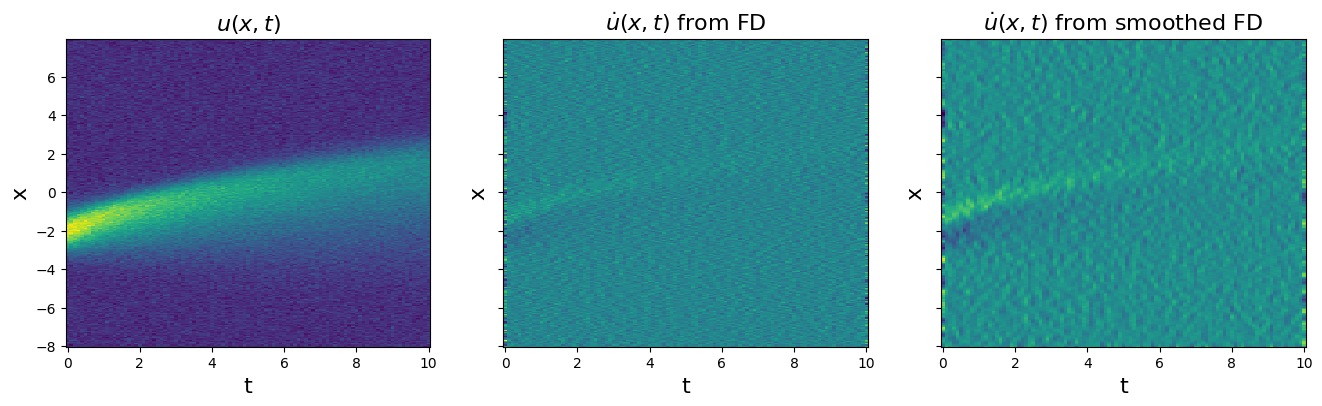

In [4]:
data = loadmat("../data/burgers.mat")
time = np.ravel(data["t"])
x = np.ravel(data["x"])
u = np.real(data["usol"])
dt = time[1] - time[0]
dx = x[1] - x[0]
rmse = mean_squared_error(u, np.zeros(u.shape), squared=False)
# add 20% noise (note the impact on derivatives depends on step size...)
u = u + np.random.normal(0, rmse / 5.0, u.shape)

# Plot u and u_dot
plt.figure(figsize=(16, 4))
plt.subplot(1, 3, 1)
plt.pcolormesh(time, x, u)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
plt.title(r"$u(x, t)$", fontsize=16)

u_dot = ps.FiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 2)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from FD", fontsize=16)

u_dot = ps.SmoothedFiniteDifference(axis=1)._differentiate(u, t=dt)
plt.subplot(1, 3, 3)
plt.pcolormesh(time, x, u_dot)
plt.xlabel("t", fontsize=16)
plt.ylabel("x", fontsize=16)
ax = plt.gca()
ax.set_yticklabels([])
plt.title(r"$\dot{u}(x, t)$ from smoothed FD", fontsize=16)
plt.show()
# See how much SmoothedFiniteDifference improves the derivatives!

u = np.reshape(u, (len(x), len(time), 1))

In [5]:
u.shape

(256, 101, 1)

In [ ]:
# Define weak form PDE library
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

# Need to define the 2D spatiotemporal grid before calling the library
X, T = np.meshgrid(x, time)
XT = np.asarray([X, T]).T
pde_lib = ps.WeakPDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatiotemporal_grid=XT,
    is_uniform=True,
    K=1000,
)

In [6]:
# Define weak form PDE library
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]

# Show that a non-weak form model screws this up badly
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=2,
    spatial_grid=x,
    include_bias=False,
    is_uniform=True,
)

# Fit and predict with the non-weak model
opt = ps.SR3(
    threshold=0.05, thresholder="l0", tol=1e-10, normalize_columns=True, max_iter=1000
)
model_for_prediction = ps.SINDy(feature_library=pde_lib, optimizer=opt)
model_for_prediction.fit(u)

# Prints a very wrong model
model_for_prediction.print()

(x0)' = 0.011 x0 + -0.031 x0x0 + -0.001 x0_1 + -0.012 x0x0_1 + -0.028 x0x0x0_1


In [4]:
library_functions = [lambda x: x, lambda x: x * x]
library_function_names = [lambda x: x, lambda x: x + x]
pde_lib = ps.PDELibrary(
    library_functions=library_functions,
    function_names=library_function_names,
    derivative_order=3,
    spatial_grid=x,
    is_uniform=True,
)

print('STLSQ model: ')
optimizer = ps.STLSQ(threshold=2, alpha=1e-5, normalize_columns=True)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SR3 model, L0 norm: ')
optimizer = ps.SR3(
    threshold=2,
    max_iter=10000,
    tol=1e-15,
    nu=1e2,
    thresholder="l0",
    normalize_columns=True,
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SR3 model, L1 norm: ')
optimizer = ps.SR3(
    threshold=0.5, max_iter=10000, tol=1e-15,
    thresholder="l1", normalize_columns=True
)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SSR model: ')
optimizer = ps.SSR(normalize_columns=True, kappa=1)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('SSR (metric = model residual) model: ')
optimizer = ps.SSR(criteria="model_residual",
                   normalize_columns=True,
                   kappa=1)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

print('FROLs model: ')
optimizer = ps.FROLS(normalize_columns=True, kappa=1e-3)
model = ps.SINDy(feature_library=pde_lib, optimizer=optimizer)
model.fit(u, t=dt)
model.print()

STLSQ model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1
SR3 model, L0 norm: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1
SR3 model, L1 norm: 
(x0)' = -0.001 x0_1 + 0.100 x0_11 + -1.000 x0x0_1
SSR model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1
SSR (metric = model residual) model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1
FROLs model: 
(x0)' = 0.100 x0_11 + -1.001 x0x0_1


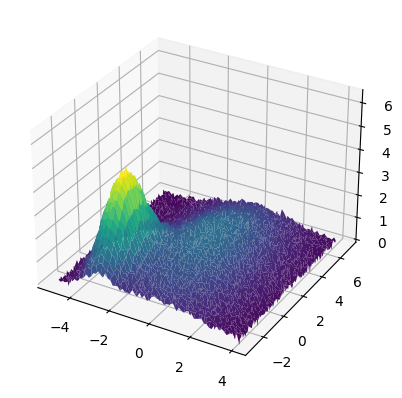

Fitted parameters:
[ 1.23079424e+00  4.43852900e-03  2.97751908e-02 -1.55419459e-01
  1.44758877e-02  1.46835511e-02 -1.47909549e-03 -3.73348178e-04
  2.43750130e-05  1.87802202e-01  2.32045140e-02 -8.07988278e-02
  2.73480264e-02  1.90374537e-03 -2.75842362e-03  1.15087310e-04
  7.99446644e-05 -8.30049949e-02  6.60170398e-02 -2.25174861e-02
 -3.87144283e-05  1.17615447e-03 -9.49266199e-05 -7.13706484e-06
  4.42270241e-03 -1.68798724e-02  9.02465242e-03 -8.80157675e-05
 -4.44538823e-04  8.24275253e-06  9.71124109e-03 -2.44316092e-03
 -5.20871682e-04  1.18962151e-04  3.53130861e-05 -2.31128231e-03
  9.93869208e-04 -2.49460874e-05 -1.37095385e-05 -1.73264352e-04
 -9.53054491e-05  4.00123948e-07  8.36048581e-05  3.22964845e-06
 -5.58966403e-06]
RMS residual = 0.19737995980323653


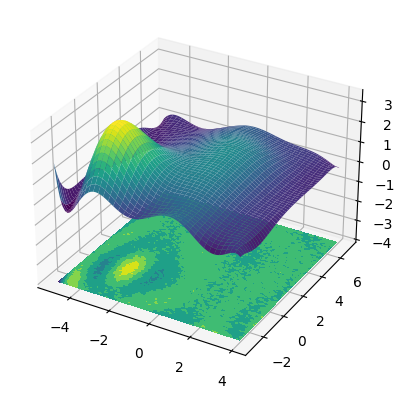

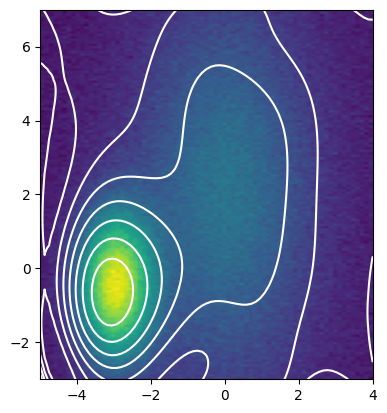

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

np.random.seed(42)

# The two-dimensional domain of the fit.
xmin, xmax, nx = -5, 4, 75
ymin, ymax, ny = -3, 7, 150
x, y = np.linspace(xmin, xmax, nx), np.linspace(ymin, ymax, ny)
X, Y = np.meshgrid(x, y)

# Our function to fit is going to be a sum of two-dimensional Gaussians
def gaussian(x, y, x0, y0, xalpha, yalpha, A):
    return A * np.exp( -((x-x0)/xalpha)**2 -((y-y0)/yalpha)**2)

# A list of the Gaussian parameters: x0, y0, xalpha, yalpha, A
gprms = [(0, 2, 2.5, 5.4, 1.5),
         #(-1, 4, 6, 2.5, 1.8),
         (-3, -0.5, 1, 2, 4),
         #(3, 0.5, 2, 1, 5)
        ]

# Standard deviation of normally-distributed noise to add in generating
# our test function to fit.
noise_sigma = 0.1

# The function to be fit is Z.
Z = np.zeros(X.shape)
for p in gprms:
    Z += gaussian(X, Y, *p)
Z += noise_sigma * np.random.randn(*Z.shape)

# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, Z, cmap='viridis')
ax.set_zlim(0,np.max(Z)+2)
plt.show()

def get_basis(x, y, max_order=4):
    """Return the fit basis polynomials: 1, x, x^2, ..., xy, x^2y, ... etc."""
    basis = []
    for i in range(max_order+1):
        for j in range(max_order - i +1):
            basis.append(x**j * y**i)
    return basis

# We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
x, y = X.ravel(), Y.ravel()
# Maximum order of polynomial term in the basis.
max_order = 8
basis = get_basis(x, y, max_order)
# Linear, least-squares fit.
A = np.vstack(basis).T
b = Z.ravel()
c, r, rank, s = np.linalg.lstsq(A, b, rcond=None)

print('Fitted parameters:')
print(c)

# Calculate the fitted surface from the coefficients, c.
fit = np.sum(c[:, None, None] * np.array(get_basis(X, Y, max_order))
                .reshape(len(basis), *X.shape), axis=0)

rms = np.sqrt(np.mean((Z - fit)**2))
print('RMS residual =', rms)

# Plot the 3D figure of the fitted function and the residuals.
fig = plt.figure()
ax = fig.add_subplot(projection='3d')
ax.plot_surface(X, Y, fit, cmap='viridis')
cset = ax.contourf(X, Y, Z-fit, zdir='z', offset=-4, cmap='viridis')
ax.set_zlim(-4,np.max(fit))
plt.show()

# Plot the test data as a 2D image and the fit as overlaid contours.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.imshow(Z, origin='lower', cmap='viridis',
          extent=(x.min(), x.max(), y.min(), y.max()))
ax.contour(X, Y, fit, colors='w')
plt.show()

In [14]:
A.shape

(11250, 45)

In [12]:
np.array(basis).shape

(45, 11250)

In [6]:
x, y = X.ravel(), Y.ravel()

In [8]:
x.shape

(11250,)